<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/Copy_of_TestingMAFExtensionGaussianLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     | 10.7MB 1.2MB/s


In [0]:
import corner

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0503 03:39:30.840438 139770617186176 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
maf_sampler_path      = './gdrive/My Drive/MPM/modules/gauss3b/maf-final/sampler'
maf_logprob_path      = './gdrive/My Drive/MPM/modules/gauss3b/maf-final/log_prob'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/maf-final/

log_prob  sampler


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [9]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size    = 256
batch_size_2  = 1
hidden_size   = 10
sample_size_z = 64
sigma_n       = 0.1
n_channels    = 1
num_comp      = 2
iaf_size      = [[512, 512], [512, 512], [512, 512], [512, 512]]
maf_prior     = tf.placeholder_with_default(True,shape=[])

saver         = tf.train.Saver()

sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

generator = hub.Module(generator_path, trainable=False)
encoder   = hub.Module(encoder_path, trainable=False)

# Define latent space prior
prior             = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
log_det_prior     = tf.linalg.logdet(prior.covariance())

# define latent space posterior


# get some masked data
x_tr              = tf.placeholder(shape=[batch_size,784,n_channels], dtype=tf.float32)
x_re              = tf.placeholder(shape=[batch_size_2,784,n_channels], dtype=tf.float32)
prior_sample      = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)
#mymask           = tf.placeholder_with_default(np.arange((784),dtype=int),shape=[784])
sigma_corr        = tf.placeholder_with_default(np.ones([batch_size_2,784,n_channels], dtype='float32')*sigma_n,shape=[batch_size_2,784,n_channels])

encoded_data      = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)

sigma             = tf.nn.softplus(sigma) + 0.0001
approx_posterior  = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[batch_size,784,1])
#vae_liklogits     = tf.boolean_mask(vae_liklogits, mymask, axis=1)

# training data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
#naive_sims        = likelihood_vae.sample(sample_size_x)
naive_mean        = likelihood_vae.mean()

# test saple from prior
prior_samples     = prior.sample(sample_size_z)

sample_liklogits  = tf.reshape(generator(prior_sample),[-1,784,n_channels])
sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()


with tf.variable_scope('maf', reuse=True):
  p1= permutation(hidden_size)
  p2= permutation(hidden_size)

  chain = tfb.Chain([tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512]),name='maf-1'),tfb.Permute(permutation=p1),\
                  tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512]),name='maf-2'),tfb.Permute(permutation=p2),\
                  tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512],shift_only=True,name='maf-3'))])
  maf = tfd.TransformedDistribution(distribution=tfd.MultivariateNormalDiag(loc=np.zeros(hidden_size, dtype='float32'),scale_identity_multiplier=1.0),bijector=chain)



loss      = -tf.reduce_mean(maf.log_prob(approx_posterior.sample()))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op    = optimizer.minimize(loss)


### move on to estimating MAP 
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size_2,hidden_size]),shape=[batch_size_2,hidden_size])
MAP                  = tf.Variable(MAP_ini)
MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))
genMAP               = tf.reshape(generator(MAP),[batch_size_2,784,n_channels])
likeli_MAP           = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).log_prob(x_re)

prior_MAP            = tf.cond(maf_prior, lambda:maf.log_prob(MAP), lambda: prior.log_prob(MAP))
posterior_MAP        = prior_MAP+likeli_MAP


loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op2              = optimizer.minimize(loss_MAP, var_list=[MAP])

MAP_mean             = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).mean()


#### do Laplace approximation
ini_val  = np.ones((batch_size_2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size_2,hidden_size)), dtype=np.float32)
  sigma_new_t = tf.constant(ini_val)
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update2          = tf.stop_gradient(mu_new.assign(MAP))

hess             = tf.hessians(-posterior_MAP,MAP)

hess             = tf.gather(hess, 0)

hess2            = tf.reduce_sum(hess, axis = 2 )

sigma_hess        = tf.linalg.inv(hess2)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_hess))

lap_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])

lap_liklogits   = tf.reshape(generator(lap_z_samples),[-1,784,n_channels])
lap_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_identity_multiplier=sigma_n))
lap_mean        = lap_likelihood.mean()



# # construct a GMM approximation from different minima

# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size,num_comp,hidden_size)), dtype=np.float32)
#   ini_val2    = np.ones((batch_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
#   sigma_gmm   = tf.constant(ini_val2)
#   sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size,num_comp,hidden_size]),shape=[batch_size,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size,num_comp,hidden_size, hidden_size]),shape=[batch_size,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = w_gmm.assign(w_est)
# update_b      = mu_gmm.assign(mu_est)
# update_c      = sigma_gmmt.assign(sigma_est)

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# gmm_sample_z  = tf.reshape(gmm.sample(sample_size_z),[-1,hidden_size])
# gmm_sample_x  = tf.reshape(tfd.Independent(tfd.Bernoulli(logits=generator(gmm_sample_z))).mean(),[sample_size_z,batch_size,784])

Instructions for updating:
Colocations handled automatically by placer.


W0503 03:41:09.539922 139770617186176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 03:41:09.856644 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 03:41:09.932131 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 03:41:10.232856 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.cast instead.


W0503 03:41:10.966660 139770617186176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 03:41:11.973438 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 03:41:15.477330 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

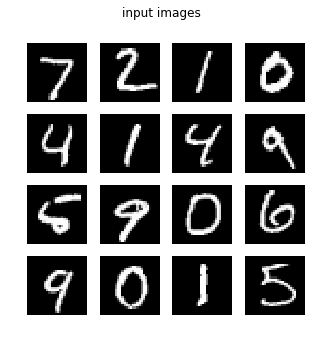

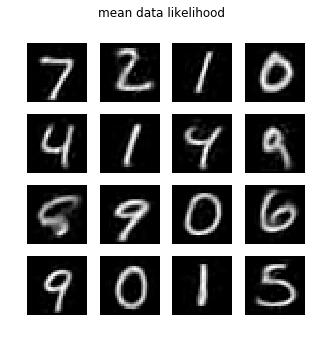

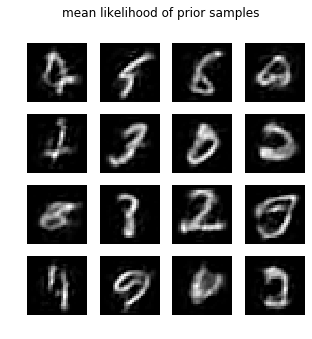

In [12]:
samples = sess.run(prior_samples, feed_dict={x_tr: np.expand_dims(x_truth,-1)})
samples.shape
inim, res, s = sess.run([x_tr,naive_mean,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_sample: samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean likelihood of prior samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
posterior_loss=[]
ii     = 0
nepoch = 0
learning_rate=1e-3

In [14]:
#train the maf
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>200:
    learning_rate=1e-3
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  posterior_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

13.526669
starting epoch 1
11.016268
starting epoch 2
10.51281
starting epoch 3
10.281664
starting epoch 4
10.088089
starting epoch 5
9.958693
starting epoch 6
9.86824
starting epoch 7
9.77253
starting epoch 8
9.663303
starting epoch 9
9.6260395
starting epoch 10
9.532612
starting epoch 11
9.491475
starting epoch 12
9.405434
starting epoch 13
9.413295
starting epoch 14
9.331779
starting epoch 15
9.3254
starting epoch 16
9.270291
starting epoch 17
9.242665
starting epoch 18
9.2237835
starting epoch 19
9.188542
starting epoch 20
9.130102
starting epoch 21
9.144715
starting epoch 22
9.090736
starting epoch 23
9.128005
starting epoch 24
9.111644
starting epoch 25
9.097051
starting epoch 26
9.106008
starting epoch 27
9.023069
starting epoch 28
8.981653
starting epoch 29
9.024707
starting epoch 30
9.005671
starting epoch 31
9.018458
starting epoch 32
9.019054
starting epoch 33
8.994712
starting epoch 34
8.996953
starting epoch 35
8.965307
starting epoch 36
8.900896
starting epoch 37
8.947318

KeyboardInterrupt: ignored

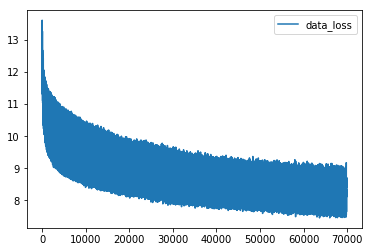

In [15]:
plt.figure()
plot(posterior_loss,label='data_loss')
legend()

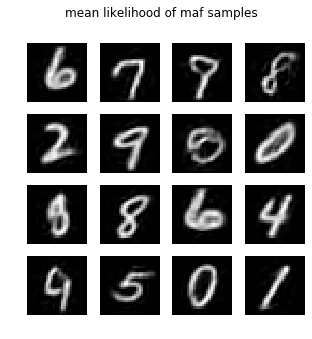

In [17]:
samples1 = sess.run(maf.sample(sample_size_z))
print(test)
#samples.shape
s = sess.run(sample_mean, feed_dict={prior_sample: samples1})



figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
# s = sess.run(sample_mean, feed_dict={prior_sample: samples2})
# figure(figsize=(5,5))
# suptitle('mean likelihood of maf samples')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')

In [0]:

#maf_log_prob.export(maf_logprob_path,sess)
#maf_sampler.export(maf_sampler_path,sess)

In [20]:
maf_s, prior_s = sess.run([maf.sample(10000), prior.sample(10000)])
print(maf_s.shape)

(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


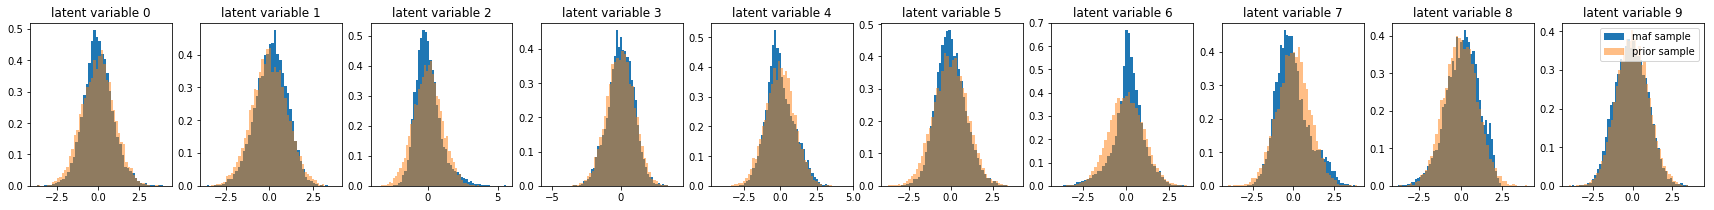

In [21]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

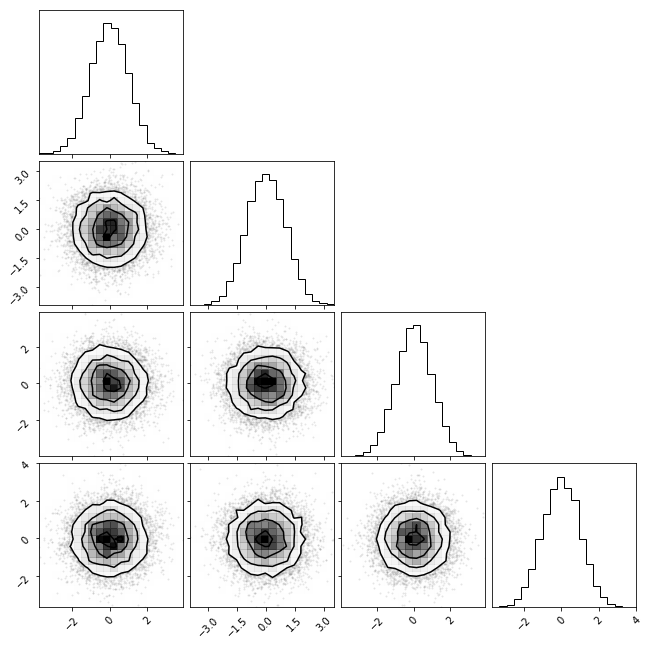

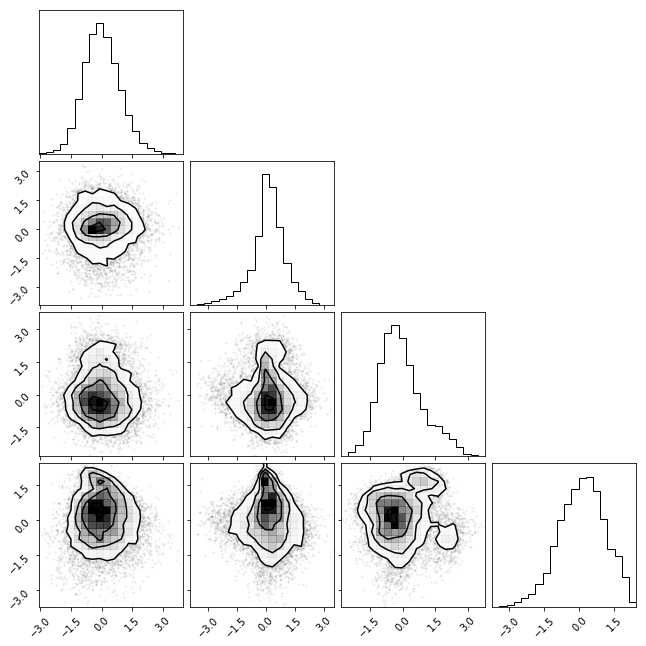

In [22]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

0
4379.9824
3794.8872
3783.543
3783.5361
3783.5295
switching to lr 0.01
3783.5632
3783.5906
3783.6113
3783.5427
3783.5256
switching to lr 0.001
3783.529
1
4490.6797
3121.3792
3016.2163
3015.474
3015.4758
switching to lr 0.01
3015.473
3015.4763
3015.4897
3015.4834
3015.4797
switching to lr 0.001
3015.4788
2
4884.121
3625.89
3445.7085
3444.9333
3444.9324
switching to lr 0.01
3444.9343
3444.9448
3444.9382
3444.9412
3444.9468
switching to lr 0.001
3444.9382
3
4364.659
3952.9622
3952.9604
3952.9521
3952.9546
switching to lr 0.01
3952.9597
3952.9807
3952.9739
3952.9673
3952.9705
switching to lr 0.001
3952.962
4
4371.106
4009.038
4005.8086
4005.8225
4005.822
switching to lr 0.01
4005.8003
4005.8032
4005.825
4005.8457
4005.7983
switching to lr 0.001
4005.8289
5
4385.305
3756.6997
3756.6545
3756.6855
3756.6733
switching to lr 0.01
3756.6829
3756.6887
3756.6868
3756.6892
3756.7585
switching to lr 0.001
3756.6567
6
4300.242
2703.381
2652.9626
2652.6772
2652.678
switching to lr 0.01
2652.6765
2652

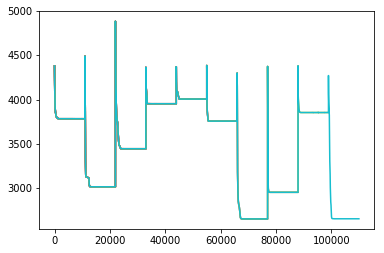

In [37]:
inc = 6
x_truth   = x_test[inc:batch_size_2+inc]
sigma_new = np.ones([28,28])*sigma_n
sigma_new[0:28,12:18]=1e8
mask=np.ones([28,28])
mask[np.where(sigma_new==1e8)]=0

data        =  np.expand_dims(x_truth,-1)
sigma_new   = sigma_new.reshape([batch_size_2,784,n_channels])
mask        = mask.reshape([batch_size_2,784,n_channels])
data        = data*mask


posterior_loss2=[]
ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))

#l_minima=[]
#map_minima=[]
for ii in range(10):
  print(ii)
  ini = np.random.rand((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(1000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_loss2,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new})]

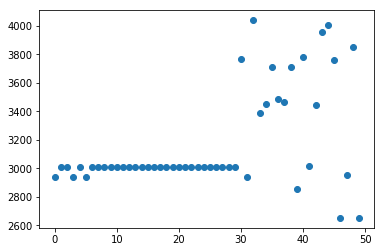

In [38]:
plt.figure()
plt.plot(np.arange(50),l_minima,ls='',marker='o')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


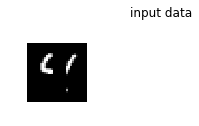

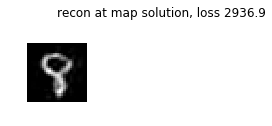

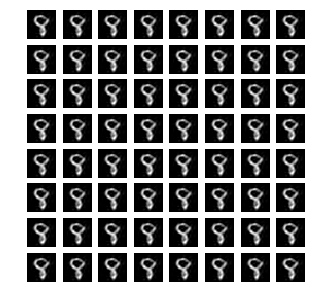

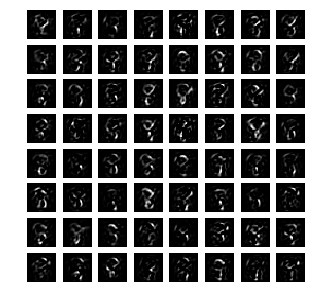

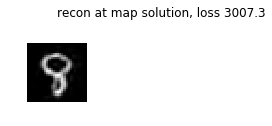

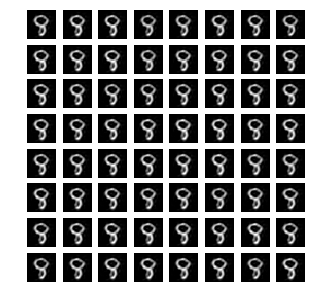

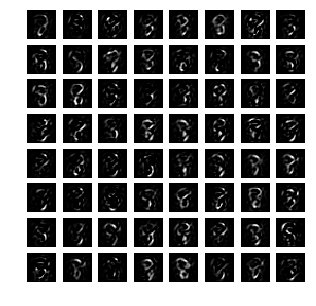

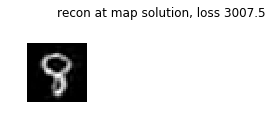

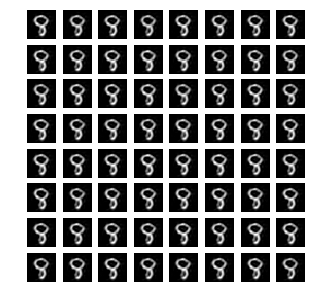

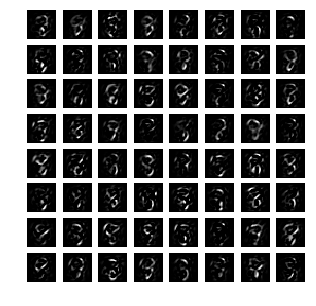

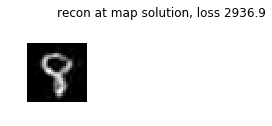

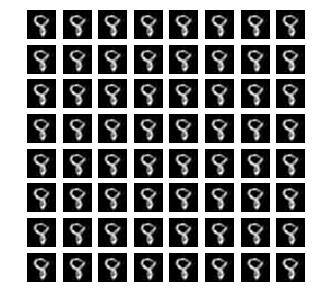

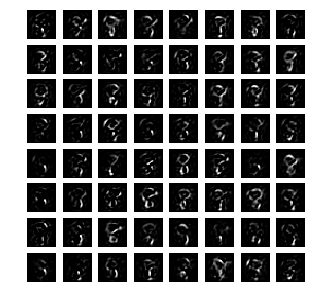

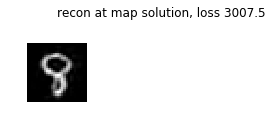

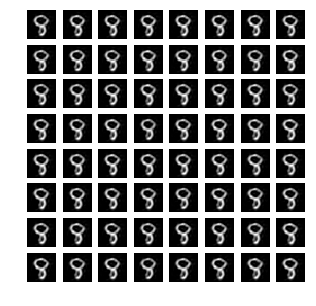

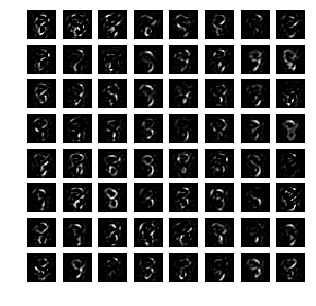

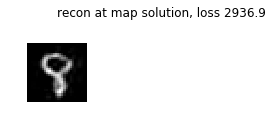

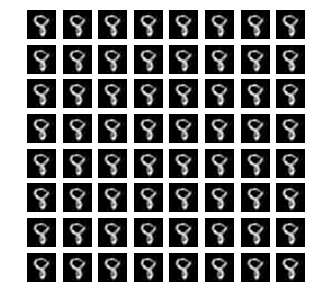

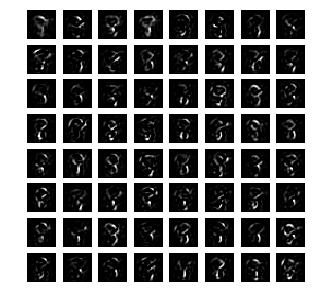

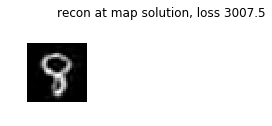

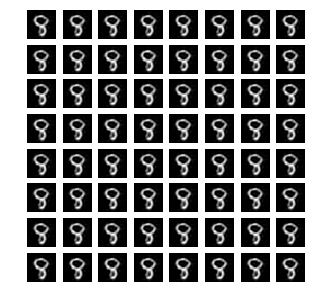

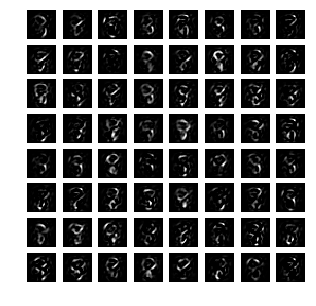

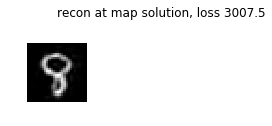

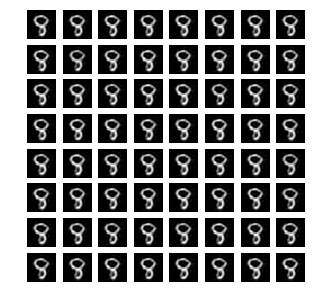

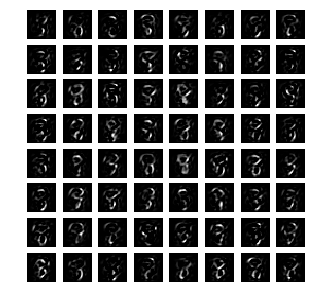

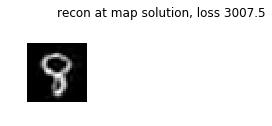

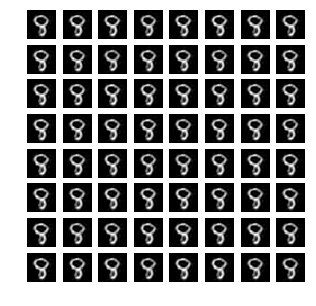

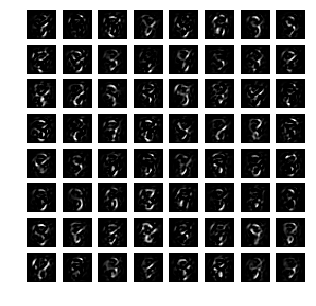

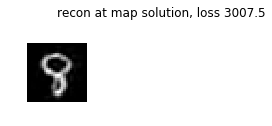

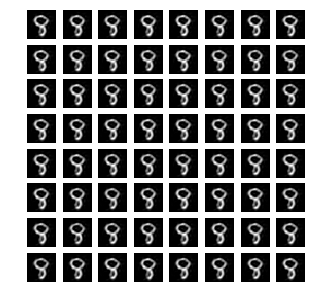

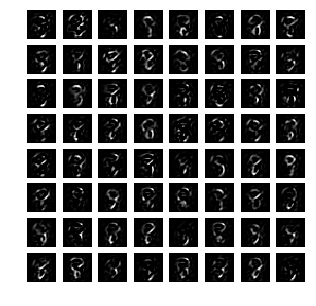

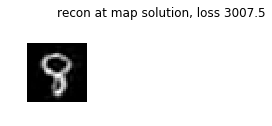

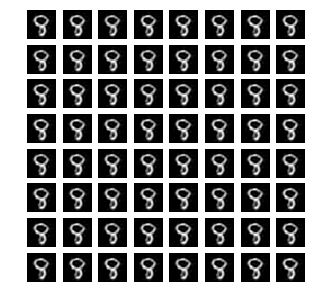

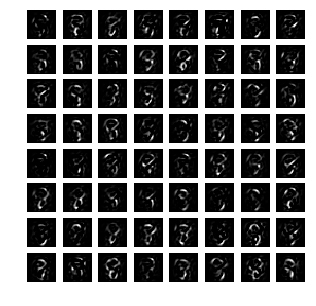

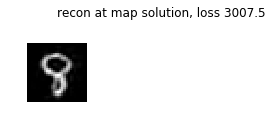

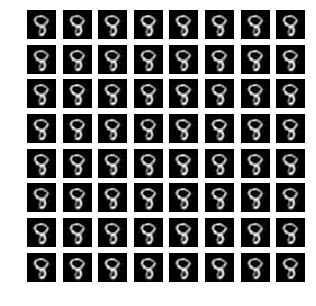

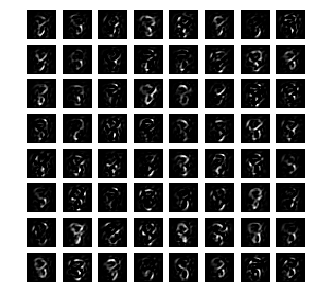

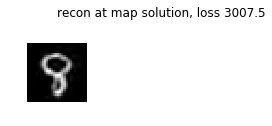

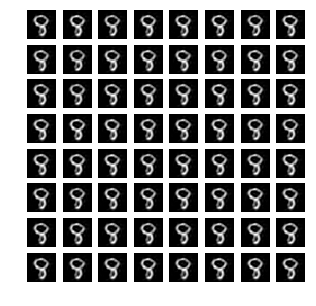

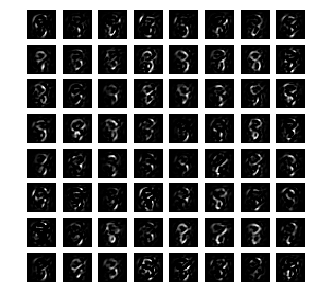

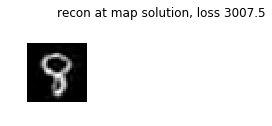

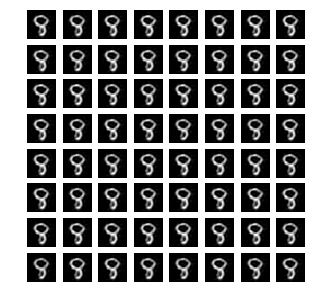

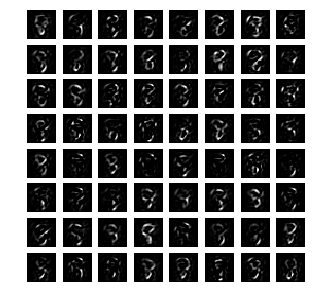

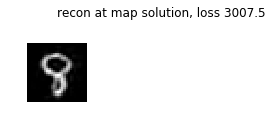

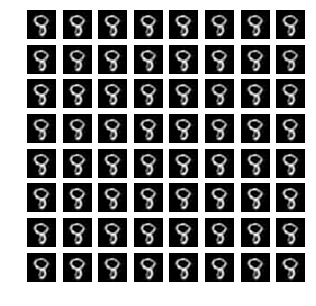

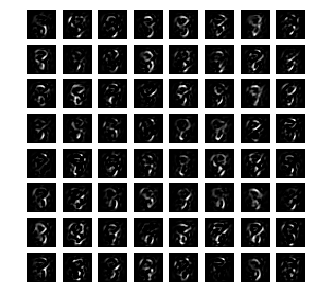

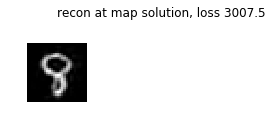

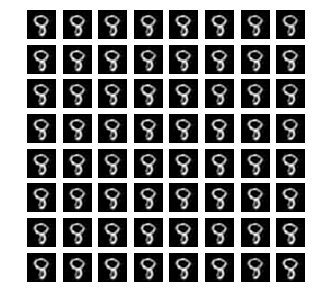

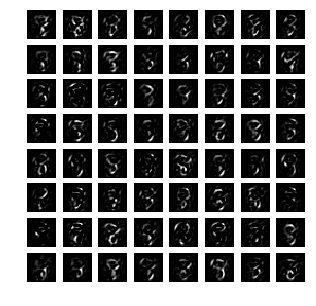

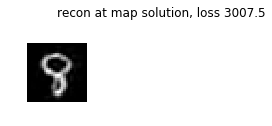

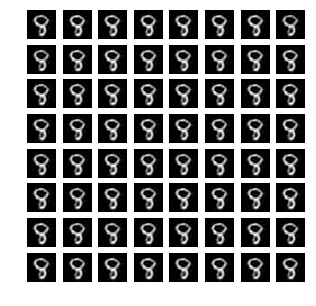

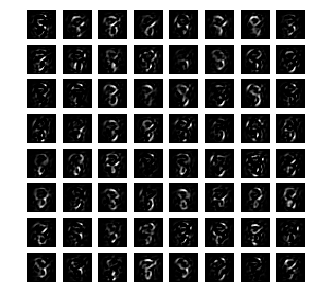

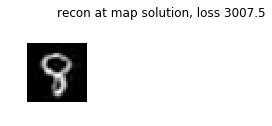

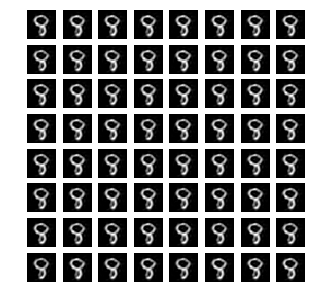

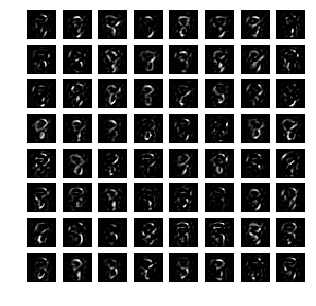

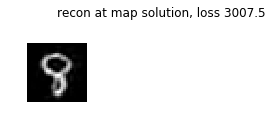

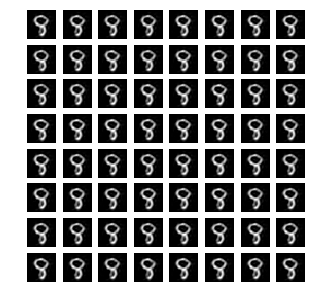

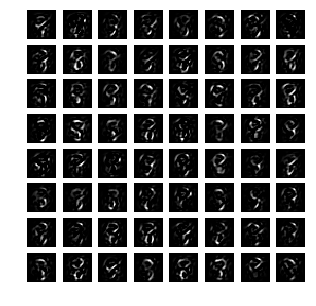

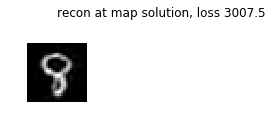

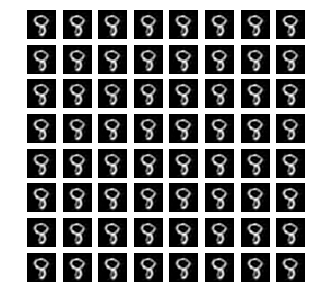

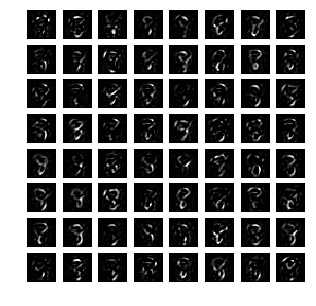

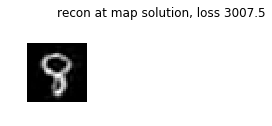

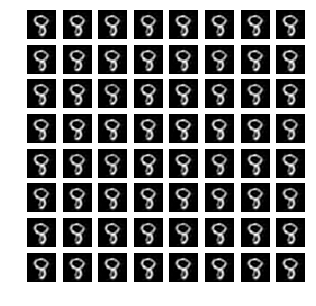

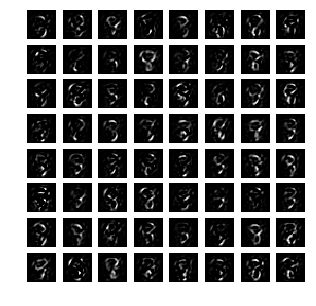

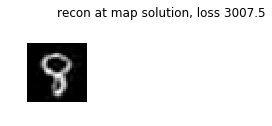

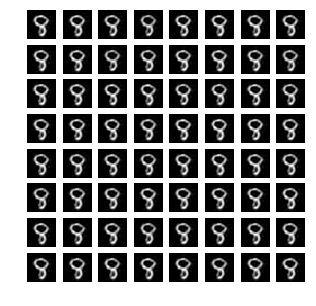

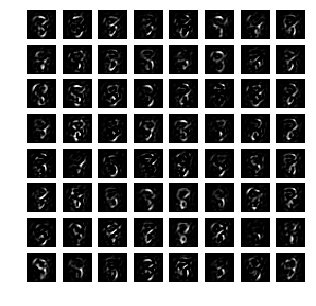

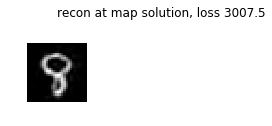

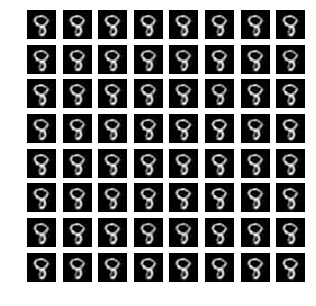

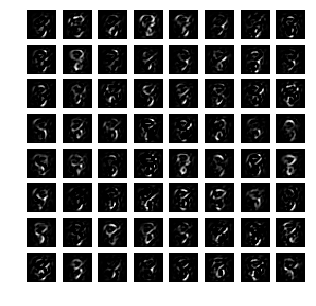

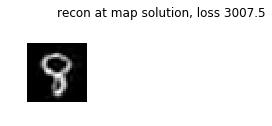

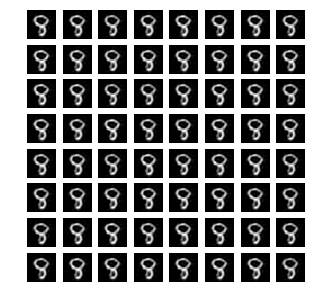

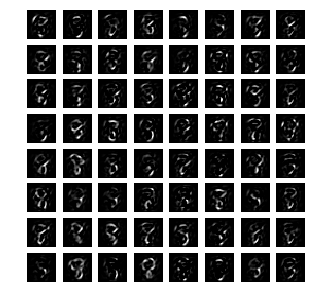

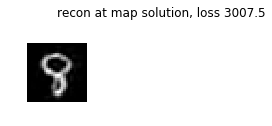

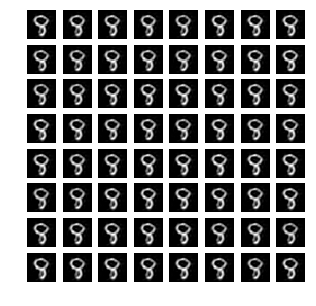

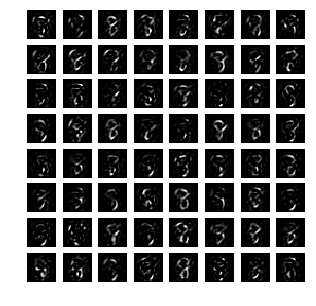

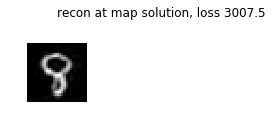

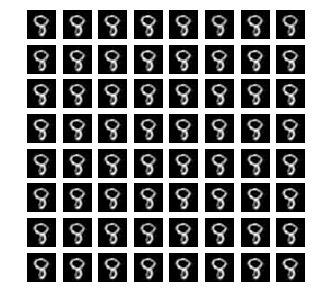

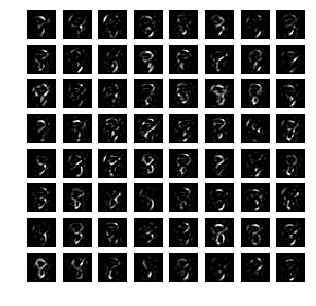

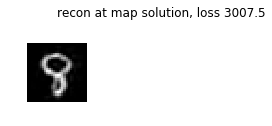

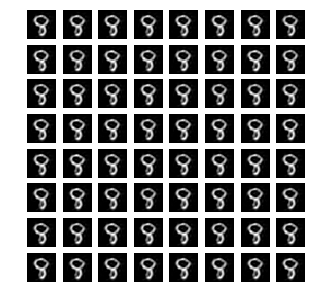

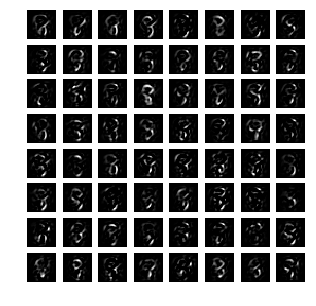

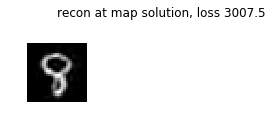

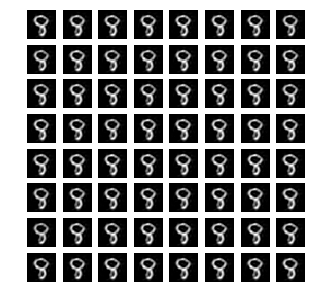

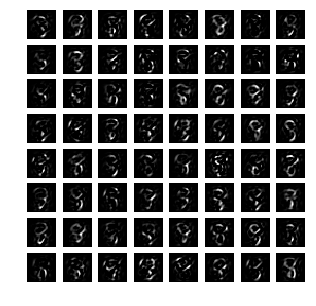

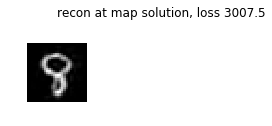

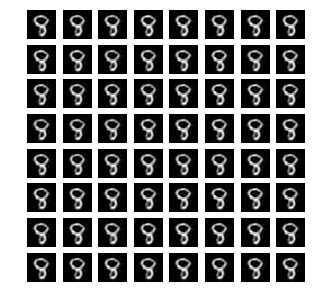

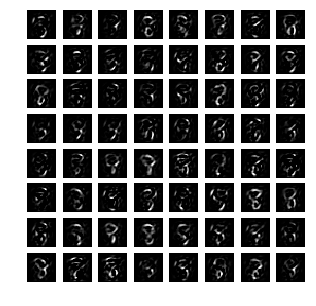

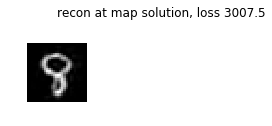

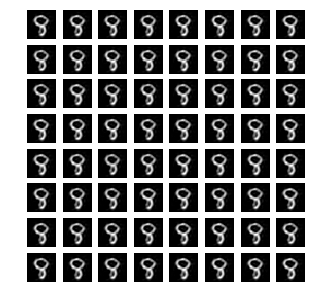

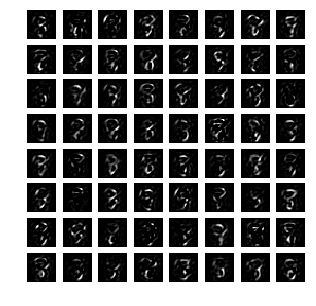

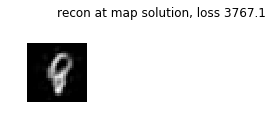

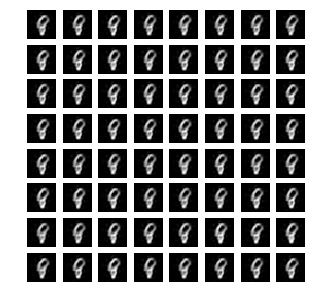

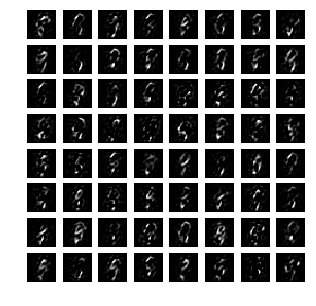

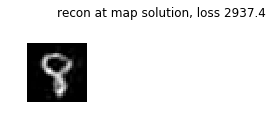

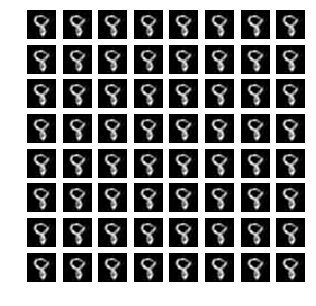

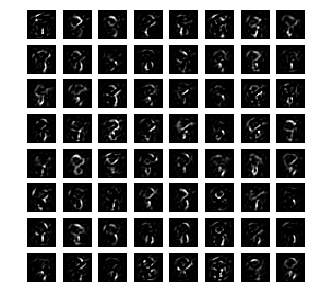

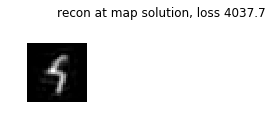

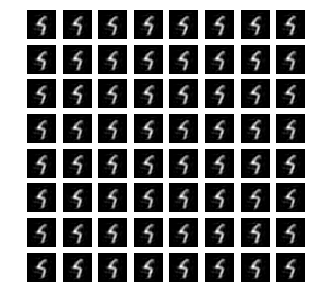

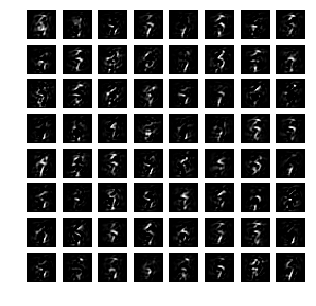

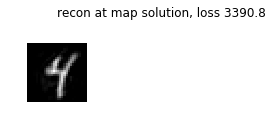

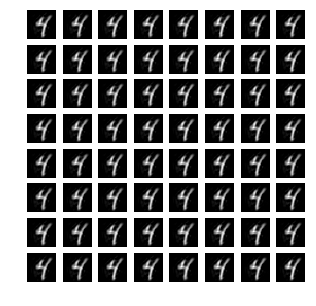

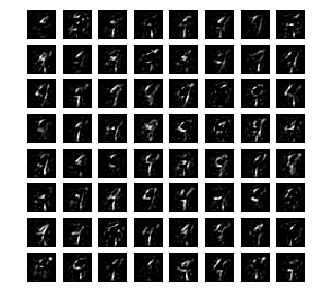

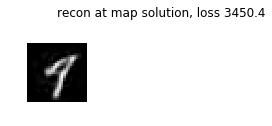

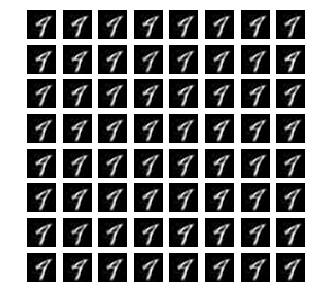

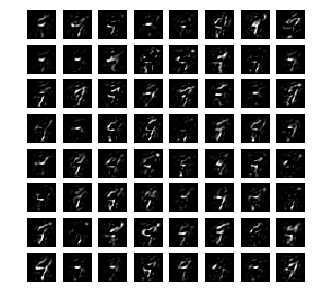

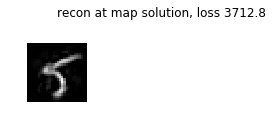

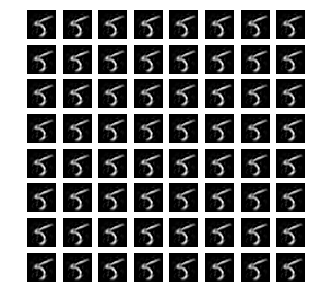

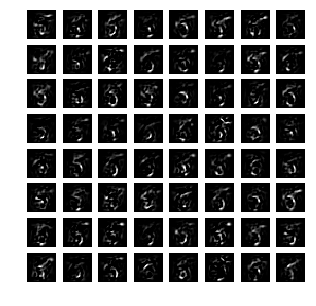

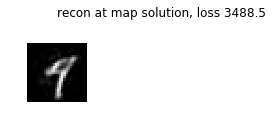

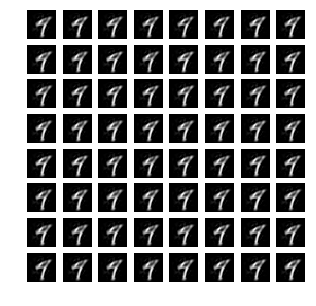

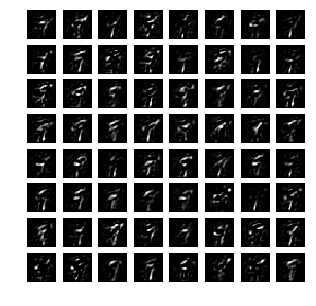

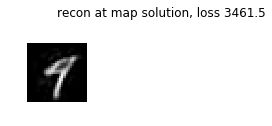

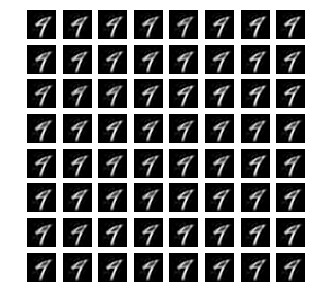

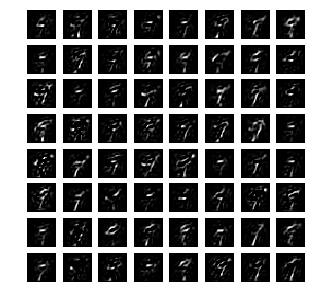

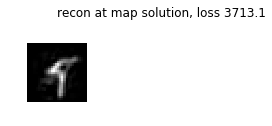

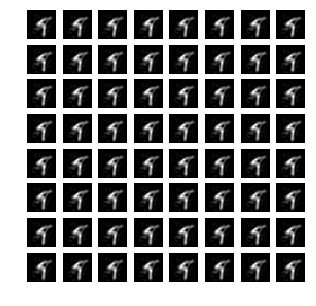

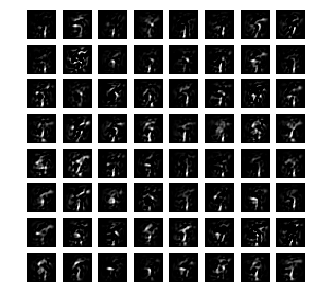

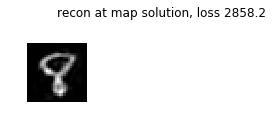

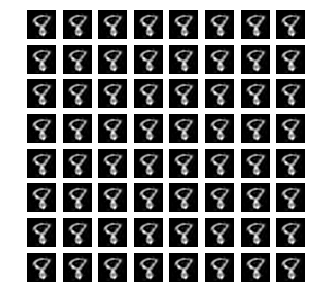

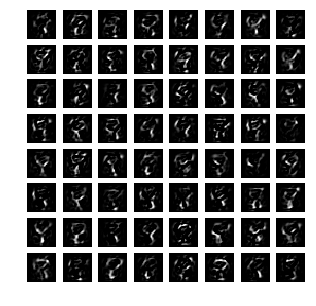

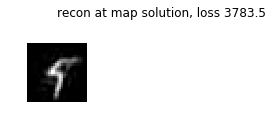

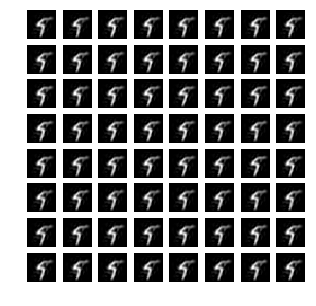

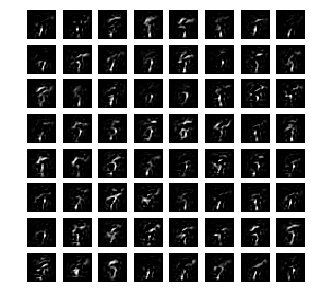

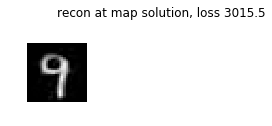

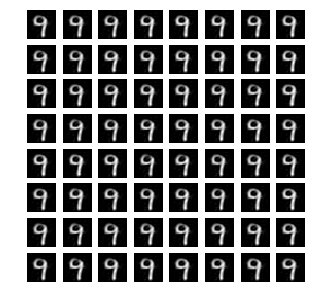

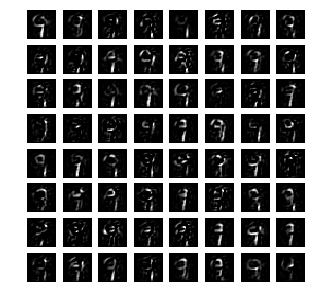

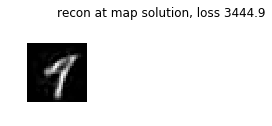

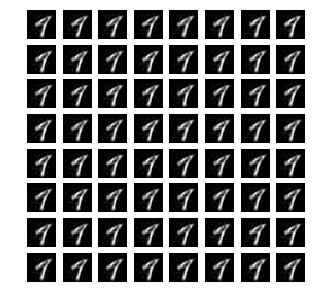

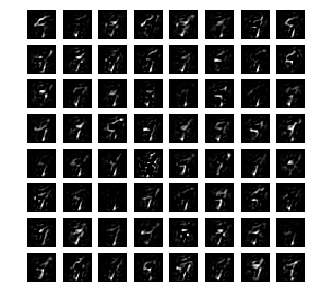

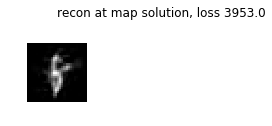

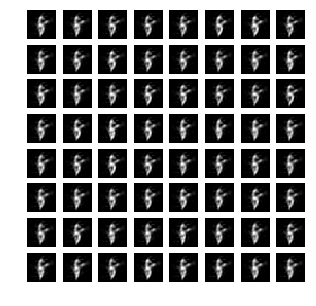

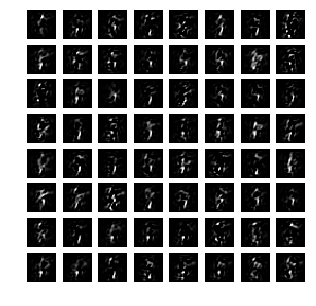

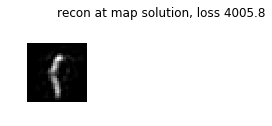

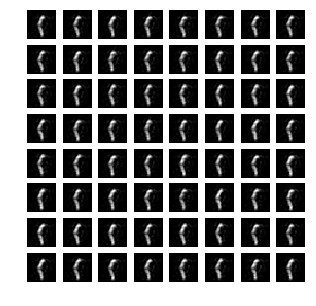

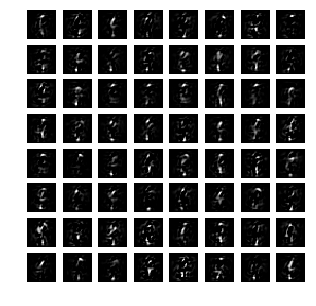

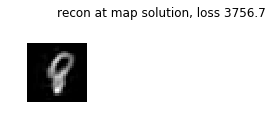

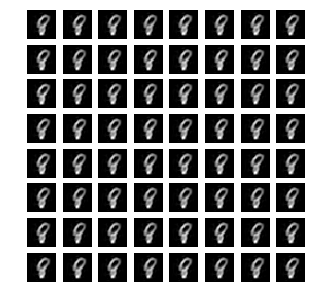

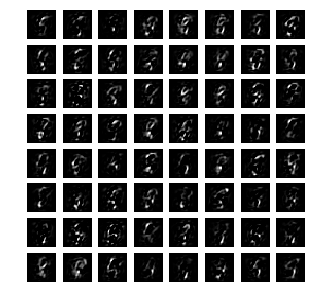

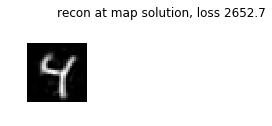

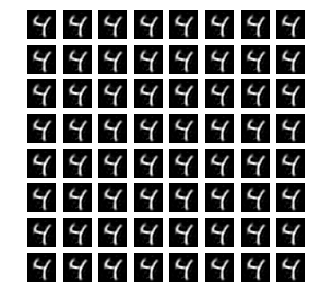

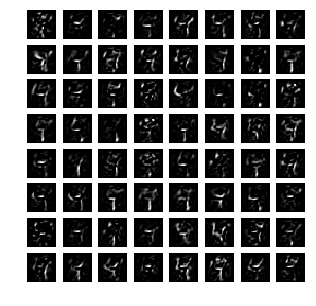

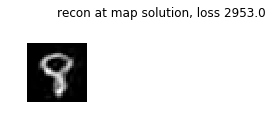

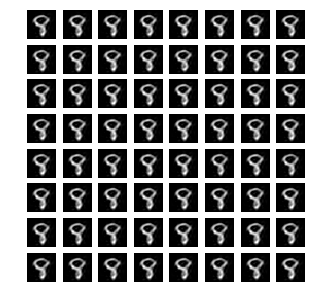

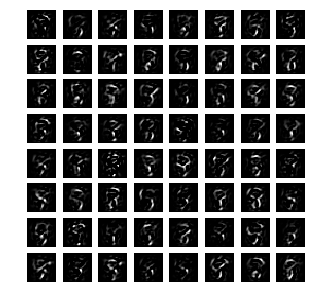

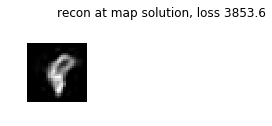

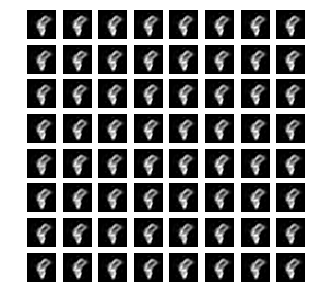

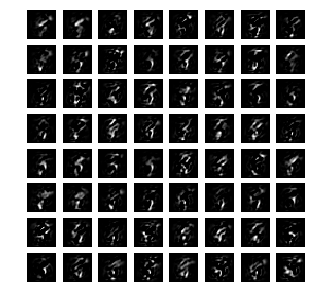

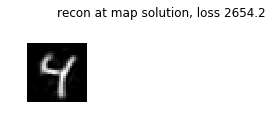

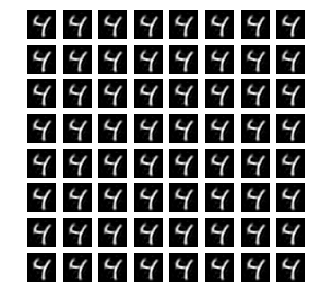

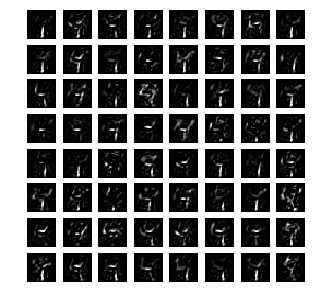

In [43]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')



for ii,ini_ in enumerate(map_minima):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new})
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new})
  
  #z_samples = sess.run(lap_z_samples,feed_dict={x_re: data, sigma_corr:sigma_new})
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  figure(figsize=(5,5))
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
  for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
    axis('off')    


4513.2363
3249.5977
3070.259
2981.0164
2907.997
2897.1682
2896.641
2896.4988
2896.4827
2896.475
2896.4502
2896.482
2896.4868
2896.449
2896.465
2896.4536
2896.463
2896.4592
2896.472
2896.4534
2896.4558
2896.4583
2896.4604
2896.4854
2896.4622


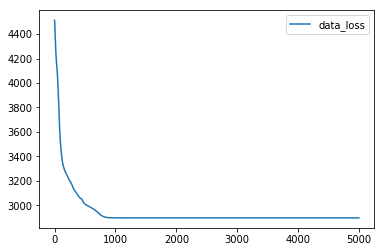

In [0]:
posterior_loss2=[]
l_minima=[]
map_minima=[]
ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, maf_prior: False, sigma_corr:sigma_new})
lrate=1e-1
for ii in range(3000):
  _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
  posterior_loss2.append(ll)
  if ii%200==0:
    print(ll)
lrate=1e-2
for ii in range(1000):
  _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
  posterior_loss2.append(ll)
  if ii%200==0:
    print(ll)
lrate=1e-4
for ii in range(1000):
  _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
  posterior_loss2.append(ll)
  if ii%200==0:
    print(ll)
l_minima+=[ll]
map_minima+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})]
plot(posterior_loss2,label='data_loss')
legend()

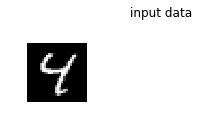

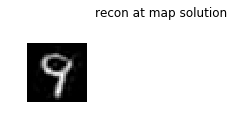

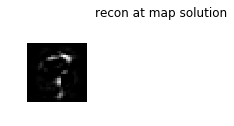

In [0]:
mean_at_map_2 = sess.run(MAP_mean,feed_dict={x_re: data, maf_prior: False, sigma_corr: sigma_new})



figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean_at_map_2[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
    

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape((mean_at_map-mean_at_map_2)[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

[[ 1.5769078  -0.36297867 -0.14089495 -0.24798092  0.79211175 -0.22583213
  -0.3639179  -0.7694447   0.456169    1.0203756 ]
 [ 1.4929073  -0.47761023 -0.12431405 -0.24138181  0.82720166 -0.17972669
  -0.3011355  -0.7770589   0.48173803  1.0262656 ]
 [ 1.5356641  -0.49658588 -0.07022396 -0.19280812  0.77491033 -0.19877481
  -0.3801086  -0.72771037  0.41862395  0.9339638 ]
 [ 1.584752   -0.4359824  -0.10060617 -0.0901819   0.7994187  -0.34595752
  -0.34989822 -0.7685668   0.39283282  0.9358777 ]
 [ 1.5805206  -0.56151795 -0.07688248 -0.16024841  0.8210018  -0.28523833
  -0.34543112 -0.7945851   0.45085022  0.86949456]
 [ 1.5304224  -0.40862215 -0.05726676 -0.13019143  0.8241793  -0.35465023
  -0.39573395 -0.7167094   0.4188679   0.9349632 ]
 [ 1.5630581  -0.3086175  -0.15645823 -0.15983969  0.7767689  -0.37402478
  -0.297944   -0.7403671   0.40270498  1.0255529 ]
 [ 1.6330857  -0.29163098 -0.19293183 -0.12063419  0.81346285 -0.42319155
  -0.38224813 -0.75398976  0.3072457   0.99352753]


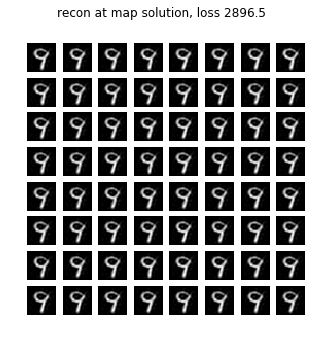

In [0]:
for ii,ini_ in enumerate(map_minima):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new,maf_prior: False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})
  
  z_samples = sess.run(lap_z_samples,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  print(z_samples)
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  print(l_samples.shape)
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')